<a id='logbook'></a>
# Ship power prediction
Analysis and development of a model to predict ship power.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

# Unmark for publish quality plots
#if os.name == 'nt':
#    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
import sys
sys.path.append('../../')
from src.notebook_to_latex import Equation, equation_dict
#from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
import src.data.load as load
from src.data.transform import transform, extend
from src.visualization.visualize import plotable_dataframe
from src.visualization.polynom import model_to_string, model_to_sympy

import plotly.express as px 
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import xgboost
import src.data.train_test_validate as train_test_validate
from sklearn.tree import DecisionTreeRegressor
## Examples:


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')

from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Full-scale measurement data of ship’s propulsion power is analyzed. Various statistics and machine learning models are fitted to predict the propulsion power based on features about the ship operational condition and data about the encountered metocean environments.  

<a id='fig_rolldecay_example>'></a>

# Data
The data used in this study is described in Tab.[(below)](#fig_data_description).

<a id="fig_data_description"></a>

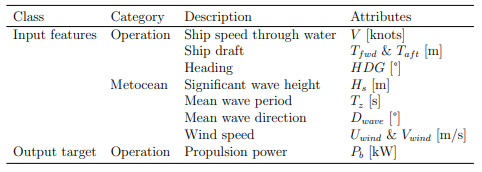

In [4]:
Image('../figures/data_description.PNG')

## Exploratory data analysis
The ship speed $V$, ship draughts $T_{aft}$ and $T_{fwd}$ were all negative in the raw data file. This was imidiatelly corrected, to be more in line with what would be expected from a more general sign convention. The data seems to have been collected in time cronological order, giving a time series of data. For a time series, measurements close to each other in time have a high correlation, as they are experiencing similar envinronmental conditions etc. This is confirmed by looking at the autocorrelation plot in Fig.[(below)](#fig_power_autocorrelation). Dead reckoning (using ship speed and heading) has been used to atempt to describe motion of the ship as seen in Fig.[(below)](#fig_dead_reckoning). The positions are given in an unknown longintude and latitude scale, as the time step between measurements is unknown. The speed of the ship is also indicated as a color gradient in this figure.

In [5]:
raw_data = load.raw()

In [6]:
display(raw_data.head())
display(raw_data.describe())
display(raw_data.dtypes)

,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
0,4096.859211,23.359333,10.25,10.2,225.120423,0.336355,4.113880,58.287071,-0.251960,0.598855
1,4062.904838,23.351923,10.25,10.2,225.121609,0.334025,4.107303,61.219389,-0.205543,0.537524
2,4105.640943,23.304333,10.25,10.2,213.803859,0.331768,4.100033,64.378446,-0.167395,0.480271
3,4156.401020,23.293167,10.25,10.2,225.124531,0.328743,4.084423,69.095584,-0.153352,0.410798
4,4147.498244,23.287000,10.25,10.2,225.125682,0.326883,4.072262,73.970302,-0.125637,0.360612


,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000
mean,3188.935287,24.278879,11.182685,11.093998,254.571157,1.666358,7.462152,204.735041,2.035780,0.747150
std,1332.289539,1.001131,0.715500,0.701950,70.481649,0.813212,1.955307,80.514470,4.931660,4.261370
min,1000.000000,22.436267,10.250000,10.160000,0.000000,0.158431,2.233657,2.680181,-11.236499,-14.531855
25%,1815.723938,23.454343,10.700000,10.600000,245.028127,1.153389,6.396379,169.396098,-0.985087,-2.065295
50%,3173.939254,24.132437,11.000000,10.800000,270.018724,1.540236,7.497403,205.961881,2.740314,0.088762
75%,4385.159249,24.897164,11.700000,11.600000,292.405334,2.160576,8.980331,268.427660,5.574664,3.568319
max,5974.050320,27.955649,12.400000,12.200000,347.212496,4.330742,11.513423,358.097469,13.623467,12.415640


Power     float64
V         float64
T_fwd     float64
T_aft     float64
HDG       float64
Hs        float64
Tz        float64
D_wave    float64
U_wind    float64
V_wind    float64
dtype: object

<a id="fig_power_autocorrelation"></a>

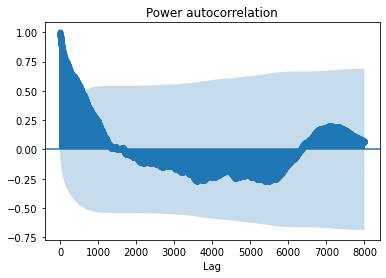

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(raw_data['Power'].values, lags=8000);
ax = fig.get_axes()[0]
ax.set_xlabel('Lag')
ax.set_title('Power autocorrelation');


In [8]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('z', raw_data['HDG'], degrees=True)
df = pd.DataFrame(index=raw_data.index)
df['u'] = raw_data['V']  ## Assuming no drift
df['v'] = 0  ## Assuming no drift
df['w'] = 0  ## Assuming no drift

df[['dX','dY','dZ']] = r.apply(df)
df[['X','Y','Z']] = df[['dX','dY','dZ']].cumsum()


<a id="fig_dead_reckoning"></a>

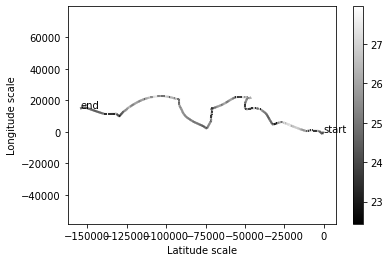

In [9]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = df['Y'].values
y = df['X'].values
dydx = df['u'].values

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='gray', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
ax.set_xlim(df['Y'].min(),df['Y'].max())
ax.set_ylim(df['X'].min(),df['X'].max())

ax.annotate('start',xy=df.iloc[0][['Y','X']])
ax.annotate('end',xy=df.iloc[-1][['Y','X']])
ax.axis('equal')
ax.set_xlabel('Latitude scale')
ax.set_ylabel('Longitude scale');

Fig.[(below)](#fig_heat_map_raw_data) shows a heat map of the absolute linear correlation coefficient between all of the features in the raw data. It can be seen that $T_{aft}$ and $T_{fwd}$ have the highest correlation with the $Power$. It can also be seen that the correlation between $T_{aft}$ and $T_{fwd}$ is also very high (approximately 1) implying a very high multicollinearity which is generally something that should be avoided in regression problems. These two features are instead replaced with the two features: mean draught $T$ and $trim$. The correspondig heat map with the new features is shown in Fig.[(below)](#fig_heat_map_data). The mean draught $T$ now seems to be a very important feature in this regression as it has the highest linear correlation with the $Power$. This can also be seen in Fig.[(below)](#fig_power_draught), where the $Power$ has been plotted together with the corresponding negative draught.

In [10]:
#
#s = StandardScaler()
#data_ = s.fit_transform(X=data)
#data_ = pd.DataFrame(data_, columns=data.columns, index=data.index)
#data_.index = pd.TimedeltaIndex(data_.index, unit='m')
#data_ = data_.resample('60min').mean()
#data_['T'] = -data_['T']
#px.line(data_frame=data_, width=1400, height=600,)

<a id="fig_heat_map_raw_data"></a>

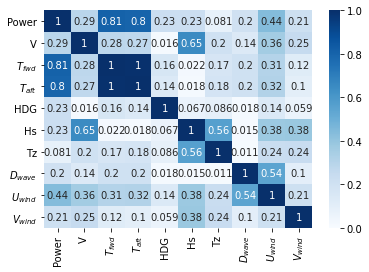

In [11]:
corr = plotable_dataframe(raw_data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<a id="fig_heat_map_data"></a>

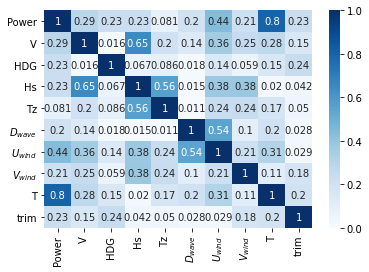

In [12]:
data = transform(raw_data=raw_data)
corr = plotable_dataframe(data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<a id="fig_power_draught"></a>

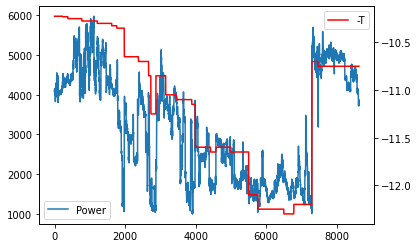

In [13]:
fig,ax=plt.subplots()

data_ = data.copy()
data_.plot(y='Power', ax=ax)
ax2 = ax.twinx()
data_['-T'] = -data_['T']
data_.plot(y='-T', style='r-', ax=ax2);


In [14]:
#s = StandardScaler()
#data_ = s.fit_transform(X=data)
#data_ = pd.DataFrame(data_, columns=data.columns, index=data.index)
#data_.index = pd.TimedeltaIndex(data_.index, unit='m')
#data_ = data_.resample('60min').mean()
#data_['T'] = -data_['T']
#fig,ax=plt.subplots()
#fig.set_size_inches(17,10)
#data_.plot(alpha=0.7, ax=ax)

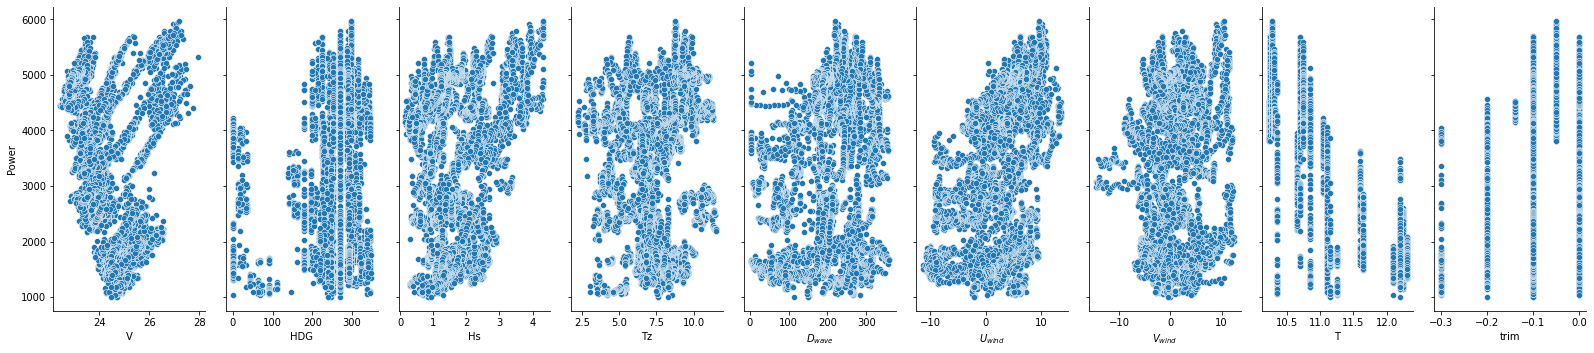

In [15]:
data_plot = plotable_dataframe(data)
x_vars = list(data_plot.columns)
x_vars.remove('Power')

g = sns.PairGrid(data_plot,y_vars='Power', x_vars=x_vars, height=5, aspect=0.5)
g.map_offdiag(sns.scatterplot);

## Extend data
The data has also been extended by adding some additional features, describing the wind speed and wave direction in a ship fixed coordinate system:$u_{wind}$, $v_{wind}$, $wave_{direction}$. The new features have very low linear correlation with $Power$ as seen in Fig.[(below)](#fig_heat_map_extended_data). They are however kept in the data, to let the regression model decide if they are useable or not.

In [16]:
data_extended = extend(data=data)

<a id="fig_heat_map_extended_data"></a>

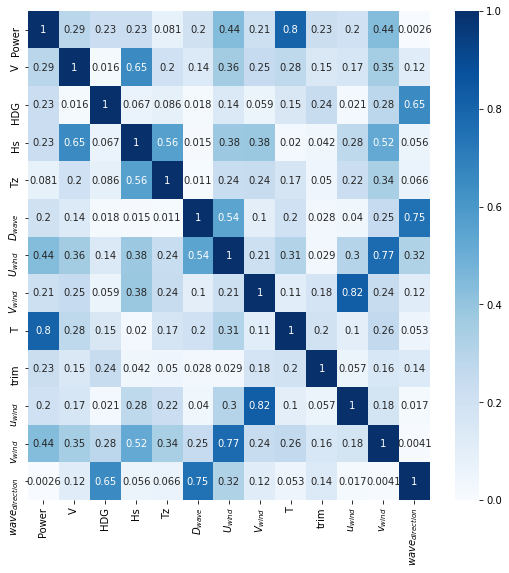

In [17]:
corr = plotable_dataframe(data_extended.corr().abs())
fig,ax = plt.subplots()
fig.set_size_inches(9,9)
ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True, ax=ax)


# Regression

The ship power data is split into a train and a test part. In the time series the samples are not independent, which means that splitting the data into a train and test set should not be done randomly! With a time series, training should be done on historic data to predict the future. This means that the training set must happen in time prior to the test set. Fig.[(below)](#fig_train_test) shows how the train-test-split should been done for the present data, where the last 20\% of the data is used for testing. 

In Fig.[(below)](#fig_train_test_random) this train/test approach (time split) has been compared with the corresponding random train/test split (random split). A decision tree model has also been trained and tested to show that the random split overestimates the accuracy by far. To ensure that this is not just a coincidence for a 20\% test, the test size has also been varied between 20\% and 70\% as seen in Fig.[(below)](#fig_test_size_variation), where the random split gets very low accuracy for the entire range, while the random split gets very good accuracy for all test sizes.

Due to the same reasoning, cross-validation on a rolling basis is used for parameter tuning as seen in Fig.[(below)](#fig_rolling_basis). 


<a id="fig_random_train_test"></a>

<a id="fig_train_test"></a>

In [35]:
X = data_extended.copy()
y = X.pop('Power')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

split_index = int(len(X)*0.8)
X_train = X.loc[0:split_index].copy()
y_train = y.loc[0:split_index].copy()

X_test = X.loc[split_index:].copy()
y_test = y.loc[split_index:].copy()


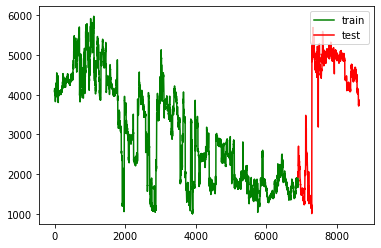

In [36]:
fig,ax=plt.subplots()
y_train.plot(style='g-', ax=ax, label='train')
y_test.plot(style='r-', ax=ax, label='test')
ax.legend(loc='upper right');

<a id="fig_train_test_random"></a>

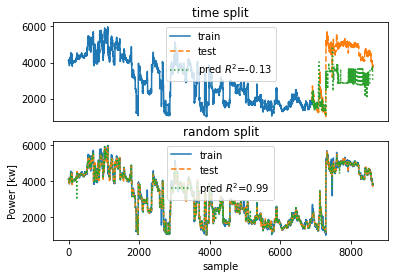

In [37]:
model = DecisionTreeRegressor(random_state=42)

test_size=0.2
df_ = pd.DataFrame()

fig,axes = plt.subplots(nrows=2)
for ax,rolling in zip(axes, [True,False]):
    
    X_train_, X_test_, y_train_, y_test_ = train_test_validate.get_train_test(data=data_extended, rolling=rolling, test_size=test_size)
    s = pd.Series()
    s['model'] = model.fit(X_train_, y_train_)
    s['score'] = score = model.score(X_test_, y_test_)
    s['rolling'] = rolling
    
    data_pred = X_test_.copy()
    data_pred['Power'] = model.predict(X_test_)
    data_pred.sort_index(inplace=True)
    
    data_train = X_train_.copy()
    data_train['Power'] = y_train_
    data_train.sort_index(inplace=True)
    
    data_test = X_test_.copy()
    data_test['Power'] = y_test_
    data_test.sort_index(inplace=True)
    
    
    data_train.plot(y='Power', ax=ax, label=f'train')
    data_test.plot(y='Power', ax=ax, label=f'test', style='--')
    data_pred.plot(y='Power', ax=ax, label=f'pred $R^2$={np.round(score,2)}', style=':')
    title = 'time split' if rolling else 'random split'
    ax.set_title(title)
    
axes[0].set_xticks([]);
axes[1].set_xlabel('sample')
axes[1].set_ylabel('Power [kw]');



<a id="fig_test_size_variation"></a>

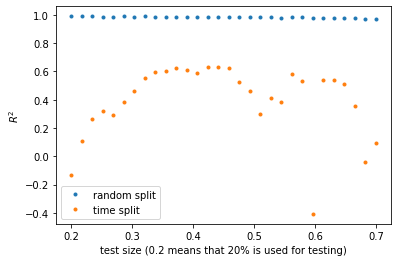

In [41]:
model = DecisionTreeRegressor(random_state=42)

df_ = pd.DataFrame()

np.random.seed(42)
for test_size in np.linspace(0.2,0.7,30):

    for rolling in [True,False]:
                
        X_train_, X_test_, y_train_, y_test_ = train_test_validate.get_train_test(data=data_extended, rolling=rolling, test_size=test_size)
        s = pd.Series()
        s['model'] = model.fit(X_train_, y_train_)
        s['score'] = score = model.score(X_test_, y_test_)
        s['rolling'] = rolling
        s['test_size'] = test_size
        df_ = df_.append(s, ignore_index=True)

fig,ax=plt.subplots()
for rolling, group in df_.groupby(by='rolling'):
    rolling_str = 'time split' if rolling else 'random split'
    label = f'{rolling_str}'
    group.plot(x='test_size', y='score', style='.', ax=ax, label=label)
    
ax.set_ylabel(r'$R^2$')
ax.set_xlabel(r'test size (0.2 means that 20% is used for testing)');

    

In [22]:
n_samples = len(X_train)
n_splits=6
test_size = n_samples // (n_splits + 1)
cv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

<a id="fig_rolling_basis"></a>

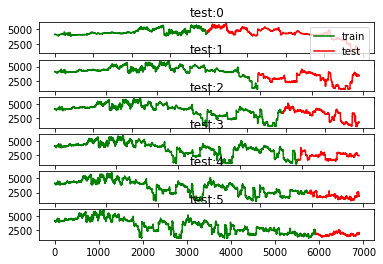

In [23]:
fig,axes=plt.subplots(nrows=n_splits)

scores=[]
for i,(train_index, test_index) in enumerate(cv.split(X_train)):
    ax = axes[i]
    X_train_ = X_train.loc[train_index]
    y_train_ = y_train.loc[train_index]
    X_test_ = X_train.loc[test_index]
    y_test_ = y_train.loc[test_index]
    
    y_train_.plot(style='g-', ax=ax, label='train')
    y_test_.plot(style='r-', ax=ax, label='test')
    ax.set_title(f'test:{i}')
    
axes[0].legend(loc='upper right');
#fig.set_size_inches(10,8)


# Validation
The accuracy of the fitted models have been estimated using two test data sets, containing 20\% and 30\% of the data. The results from this evaluation in seen in Tab.[(below)](#tab_test_validataion) and Fig.[(below)](#fig_test_evaluation). The actual predictions on the test dataset is also plotted in Fig.[(below)](#fig_predictions). The Support Vector Regressor seems to be the model that performs the best. However, none of the models seem to perform very well on this dataset and the accuracy changes very much with the test size, which means that the ranking between the models is very unreliable. So one might as well use the simple polynomial regression. The explicit formula from this regression is shown in Eq.[(below)](#eq_model_polynomial). It can be seen from this expression that the $Power$ depends on the ship draught $T$ and one of the wind components $U_{wind}$. There is however also a very high interception term, which means that most of the $Power$ is not explained by this model, if we assume that $Power$ is zero when the ship is at rest in the harbour.

In [24]:
from mlflow.tracking import MlflowClient
from src import mlflow_utils
client = MlflowClient()
client.list_experiments()

[<Experiment: artifact_location='file:///E:\\dev\\ship_power_prediction\\models\\mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///E:\\dev\\ship_power_prediction\\models\\mlruns/1', experiment_id='1', lifecycle_stage='active', name='rolling_fit', tags={}>,
 <Experiment: artifact_location='file:///E:\\dev\\ship_power_prediction\\models\\mlruns/2', experiment_id='2', lifecycle_stage='active', name='random_fit', tags={}>]

In [25]:
experiments = ['random_fit','rolling_fit']

In [26]:
import mlflow
from mlflow.entities import ViewType
from datetime import datetime, timezone

df_runs = pd.DataFrame()
models = {}
for experiment_name in experiments:
    experiment = client.get_experiment_by_name(experiment_name)
    
    for r in mlflow.list_run_infos(experiment.experiment_id, run_view_type=ViewType.ALL):
        
        run = mlflow.get_run(run_id=r.run_id)
        data = {}
        data.update(run.data.metrics)
        data.update(run.data.params)
        s=pd.Series(data=data, name=r.run_id)
        s['experiment'] = experiment_name
        
        epoch_time = run.info.start_time/1000
        s['start_time'] = datetime.fromtimestamp(epoch_time)
         
        try:
            s['model'] = mlflow_utils.load_model(run)
        except:
            pass
        
        df_runs = df_runs.append(s)
        
df_runs['rolling_cv']=df_runs['rolling_cv'].apply(lambda x : True if x=='1.0' else x)
df_runs['rolling_test']=df_runs['rolling_test'].apply(lambda x : True if x=='1.0' else x)
df_runs['rolling_cv']=df_runs['rolling_cv'].apply(lambda x : False if x=='0.0' else x)
df_runs['rolling_test']=df_runs['rolling_test'].apply(lambda x : False if x=='0.0' else x)

df_runs['test_size'] = df_runs['test_size'].astype(float)

df_runs.sort_values(by='start_time', ascending=False, inplace=True)

In [27]:
df_runs_selected = df_runs.dropna(subset=['run_name','rolling_cv'])
mask = df_runs_selected['run_name'] == 'testing'
df_runs_selected=df_runs_selected.loc[~mask]
df_runs_selected.head()

,data_path,experiment,input_path,mean_absolute_error,model,model_name,n_repeats,n_splits,output_path,r2_score,rolling,rolling_cv,rolling_test,run_name,start_time,test_size
baff131093e8441b956049aef1e2f396,../../data/processed/data_extended.csv,random_fit,pipeline/03.5_train_lasso.ipynb,1046.260920,"(StandardScaler(), PolynomialFeatures(degree=1...",lasso,1,6,artifacts\lasso_random_0.1.ipynb,-8.422626,True,False,True,lasso_random_0.1,2021-06-15 08:19:54.190,0.1
9c8d937f405e4bc8bb0f92019634ce61,../../data/processed/data_extended.csv,random_fit,pipeline/03.5_train_lasso.ipynb,819.729007,"(StandardScaler(), PolynomialFeatures(degree=1...",lasso,1,6,artifacts\lasso_random_0.3.ipynb,0.580757,True,False,True,lasso_random_0.3,2021-06-14 21:56:06.740,0.3
268ebddcc63640f98a41051fe7b91f7a,../../data/processed/data_extended.csv,random_fit,pipeline/03.5_train_lasso.ipynb,1063.004566,"(StandardScaler(), PolynomialFeatures(degree=1...",lasso,1,6,artifacts\lasso_rolling_0.3.ipynb,0.451840,True,True,True,lasso_rolling_0.3,2021-06-14 21:55:37.903,0.3
0fe11365a6fe47188b1acaa7e809d6f8,../../data/processed/data_extended.csv,random_fit,pipeline/03.5_train_lasso.ipynb,1114.798540,"(StandardScaler(), PolynomialFeatures(degree=1...",lasso,1,6,artifacts\lasso_random_0.2.ipynb,0.121825,True,False,True,lasso_random_0.2,2021-06-14 21:55:12.659,0.2
c07cc28610374c62bfebc93cc4f6b4ac,../../data/processed/data_extended.csv,random_fit,pipeline/03.5_train_lasso.ipynb,999.131658,"(StandardScaler(), PolynomialFeatures(degree=1...",lasso,1,6,artifacts\lasso_rolling_0.2.ipynb,0.294661,True,True,True,lasso_rolling_0.2,2021-06-14 21:54:41.701,0.2


In [28]:
index_columns = ['test_size','rolling_cv','rolling_test','model_name']
mask = df_runs_selected.duplicated(subset=index_columns, keep='first')
df_runs_selected2 = df_runs_selected.loc[~mask].copy()

In [29]:
interesting = ['model_name','n_repeats','n_splits','rolling_cv','rolling_test','test_size','r2_score','mean_absolute_error']
df_table = df_runs_selected2[interesting].sort_values(by=index_columns).copy()
df_table

,model_name,n_repeats,n_splits,rolling_cv,rolling_test,test_size,r2_score,mean_absolute_error
a52b044264ef4a7e94e63926dc7cf29e,SVR,1,6,False,True,0.1,-2.962466,648.678248
9ff97491a669473fbf1a41b9ec543da8,XGBoost,1,6,False,True,0.1,0.035101,301.473367
baff131093e8441b956049aef1e2f396,lasso,1,6,False,True,0.1,-8.422626,1046.260920
81d2fbbcbad94522bf7130391b070384,polynomial,1,6,False,True,0.1,-8.422626,1046.260920
f5b8ebe0ffa740619229d9ffd7e76152,ridge,1,6,False,True,0.1,-8.429016,1046.657750
ca25d047e7604e3fb8646b3988a39511,SVR,1,6,True,True,0.1,-2.962466,648.678248
e276ec46c1214ddcae3cd49e1db668c6,XGBoost,1,6,True,True,0.1,0.035101,301.473367
132dde91cfcb40dd974ad6933cdba014,lasso,1,6,True,True,0.1,-9.147163,1121.148434
7d0c316c3d394279aa734a55052529fd,polynomial,1,6,True,True,0.1,-9.147163,1121.148434
d4434190fb4a41a5a5772172ca51d57c,ridge,1,6,True,True,0.1,-9.151453,1121.389415


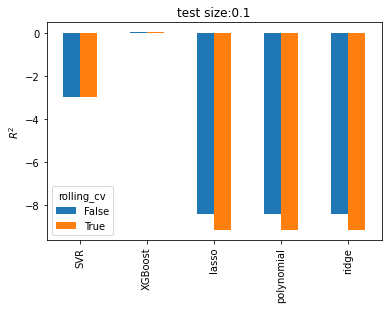

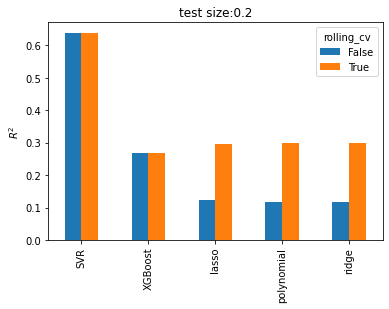

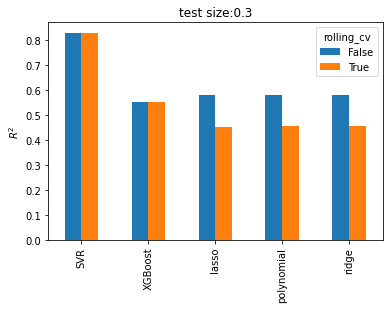

In [30]:
for test_size, group in df_table.groupby(by='test_size'):

    df_pivot = group.pivot(index='model_name', columns=['rolling_cv'])
    
    fig,ax=plt.subplots()
    df_pivot.plot(y='r2_score', kind='bar', ax=ax)
    ax.set_ylabel(r'$R^2$');
    ax.set_xlabel('');
    ax.set_title(f'test size:{test_size}')

<a id="tab_test_validataion"></a>

In [40]:
df_table_cv = df_runs_selected2.groupby(by=['rolling_cv']).get_group((True))
mask = df_table_cv['test_size'] > 0.1
df_table_cv = df_table_cv.loc[mask].copy()

interesting = ['model_name','test_size','r2_score','mean_absolute_error']
df_ = df_table_cv[interesting].copy()
renames = {key:key.replace('_',' ') for key in df_.columns}
df_.sort_values(by=['test_size','model_name'], inplace=True)
df_ = df_.round(decimals=2)
LateXTable(df=df_,units={'model_name':''},
           rename=renames,
           caption='Models evaluated with the test sets',
           label='test_validataion',)

model name,test size,r2 score,mean absolute error
,,,
SVR,0.2,0.64,687.07
XGBoost,0.2,0.27,976.96
lasso,0.2,0.29,999.13
polynomial,0.2,0.3,997.36
ridge,0.2,0.3,997.54
SVR,0.3,0.83,510.07
XGBoost,0.3,0.55,856.03
lasso,0.3,0.45,1063.0
polynomial,0.3,0.45,1060.51


<a id="fig_test_evaluation"></a>

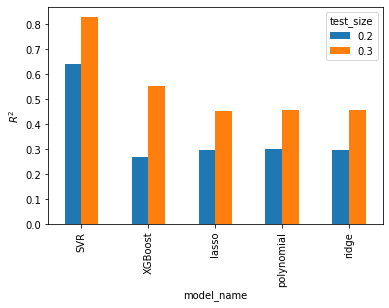

In [32]:

df_pivot = df_table_cv.pivot(index='model_name', columns=['test_size'])
    
fig,ax=plt.subplots()
df_pivot.plot(y='r2_score', kind='bar', ax=ax)
ax.set_ylabel(r'$R^2$');

<a id="fig_predictions"></a>

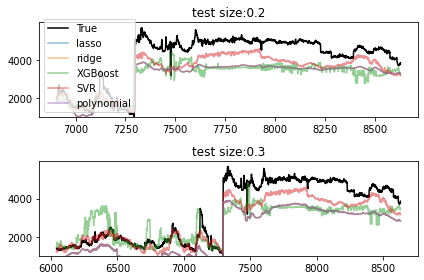

In [33]:
groups = df_table_cv.groupby(by=['test_size'])
fig,axes=plt.subplots(nrows=2)
axes = axes.flatten()
for ax,(test_size, group) in zip(axes,groups):
        
    _,X_test_,_, y_test_ =train_test_validate.get_train_test(data=data_extended, rolling=True, test_size=test_size)
    X_test_.sort_index(inplace=True)
    y_test_.sort_index(inplace=True)
    
    y_test_.plot(ax=ax, style='k-', label='True')
    
    for run_id, run in group .iterrows():
    
        model = run['model']
        y_pred = model.predict(X_test_)
        
        ax.plot(y_test_.index, y_pred, label=run['model_name'], alpha=0.5)

    ax.set_title(f'test size:{test_size}')
    ax.set_ylim(data_extended['Power'].min(),data_extended['Power'].max())

axes[0].legend();
plt.tight_layout()

<a id="eq_model_polynomial"></a>

In [34]:
row = df_runs_selected2.groupby(by=['test_size', 'rolling_cv','model_name']).get_group((0.2,True,'polynomial'))
model = row['model'].values[0]
Equation(model_to_sympy(model=model, feature_names=X.columns), 'model_polynomial')

<src.notebook_to_latex.Equation object>

# Conclusions
This dataset is a time series with high autocorrelation, so that the samples cannot be assumed as independent. This means that randomly splitting the data into a train and test dataset will overpredict the accuracy by far. With a time series, training should be done on historic data to predict the future. This means that the training set must happen in time prior to the test set, which has been done in this report for the test evaluation as well as in the cross validation for parameter tuning.

The Support Vector Regressor seems to be the model that performs the best. However, none of the models seem to perform very well on this dataset and the accuracy changes very much with the test size, which means that the ranking between the models is very unreliable. The dataset should be further examined and extended with additional features to enable for a better model fit.



# References
<div class="cite2c-biblio"></div>